## 3.2. Topic Modeling
We will use Latent Dirichlet Allocation to identify sets of words that characterize a topic.

In [1]:
import time
import datetime
from collections import Counter, defaultdict
import xml.etree.ElementTree as ET
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import os
import sys
import re
import time
import urllib
import feedparser
import random
from dateutil import parser
from urllib.request import urlretrieve, urlopen
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
store = pd.HDFStore("../data/save_final.h5") #Requires tables
#store['big_df'] = big_df
big_df = store['big_df']
store.close()

In [3]:
len(big_df)

72791

In [5]:
big_df.head()

,title,abstract,categories,created,id,doi,category,category_long,Year,clean_abstracts
1431,IIGHGINT: A generalization to the modified GHG...,A global agreement on how to reduce and cap hu...,[q-fin.GN],2014-01-01,1401.0301,None,q-fin,Quantitative Finance,2014,global agreement how reduce cap human footprin...
1432,Emergence of statistically validated financial...,According to the leading models in modern fina...,[q-fin.ST],2014-01-02,1401.0462,None,q-fin,Quantitative Finance,2014,accord lead model modern finance presence intr...
1433,Optimal Investment with Transaction Costs and ...,Two major financial market complexities are tr...,[q-fin.PM],2014-01-02,1401.0562,None,q-fin,Quantitative Finance,2014,major financial market complexity be transacti...
1435,Second order statistics characterization of Ha...,We show that the jumps correlation matrix of a...,"[stat.ME, math.ST, physics.geo-ph, q-fin.ST, q...",2014-01-05,1401.0903,None,q-fin,Quantitative Finance,2014,show jump correlation matrix multivariate hawk...
1436,An Empirical Method to Measure Stochasticity a...,An empirical algorithm is used here to study t...,"[q-fin.ST, physics.soc-ph]",2014-01-07,1401.1292,10.1103/PhysRevE.88.062912,q-fin,Quantitative Finance,2014,empirical algorithm be use here study stochast...


In [5]:
big_df = big_df[big_df.category != 'stats']
big_df = big_df[big_df.Year > 2013]

In [6]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import time # to know how long training took
import multiprocessing # to speed things up by parallelizing

In [8]:
import spacy
nlp = spacy.load('en_core_web_sm')
def clean(text):
    return ' '.join([token.lemma_ 
            for token in nlp(text) 
            if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X'}])
# Clean and remove empty observations
big_df['clean_abstract'] = big_df['abstract'].apply(clean) #Takes a while
big_df = big_df[big_df['clean_abstract'].notnull()]
len(big_df)

21754

In [9]:
store1 = pd.HDFStore("../data/save_final1.h5") #Requires tables
store1['big_df'] = big_df
#df = store['df']
store1.close()

HDF5ExtError: HDF5 error back trace

  File "H5G.c", line 683, in H5Gclose
    not a group

End of HDF5 error back trace

Problems closing the Group big_df

In [8]:
store1.close()

HDF5ExtError: HDF5 error back trace

  File "H5G.c", line 683, in H5Gclose
    not a group

End of HDF5 error back trace

Problems closing the Group big_df

In [6]:
store1 = pd.HDFStore("../data/save_final1.h5") #Requires tables
#store['big_df'] = big_df
big_df = store1['big_df']
store.close()

KeyError: 'No object named big_df in the file'

I had to reduce the number of tokens because the algorithm was overpowering my pc and hanging the kernel.

In [34]:
limit=50000
big_df = big_df.reset_index()
# get dictionary
big_df['clean_abstract'] = big_df.clean_abstract.apply(str)
# run on 50000 instances
instances = big_df.clean_abstract.apply(str.split)[:limit]
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=500, no_above=0.3)
print(dictionary, flush=True)

creating dictionary
Dictionary(720 unique tokens: ['action', 'address', 'also', 'attention', 'call']...)


In [35]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [36]:
print(instances[0])
print(ldacorpus[0]) 
print(model_corpus[0])

['global', 'agreement', 'how', 'reduce', 'cap', 'human', 'footprint', 'especially', '-PRON-', 'emission', 'be', 'very', 'unlikely', 'future', 'same', 'time', 'bilateral', 'agreement', 'would', 'be', 'inefficient', '-PRON-', 'neural', 'balanced', 'nature', 'therefore', 'unilateral', 'action', 'would', 'have', 'attract', 'attention', 'practical', 'option', 'however', 'unilateral', 'action', 'would', 'most', 'likely', 'fail', 'be', 'not', 'fair', 'also', 'be', 'not', 'consistent', 'world', 'trade', 'organization', 'rule', 'consider', 'highly', 'heterogeneity', 'global', 'economy', 'modify', 'intensity', 'indicator', 'hereafter', 'call', 'adjust', 'base', 'be', 'put', 'forward', 'address', 'need', 'form', 'universal', 'indicator', 'applicable', 'region', 'regardless', '-PRON-', 'economic', 'social', 'status', 'nonetheless', 'original', 'indicator', 'ignore', 'hidden', 'consumption', 'relate', 'emission', 'therefore', 'could', 'be', 'unfair', 'production', 'orient', 'region', 'current', 'bi

In [38]:
coherence_values = []

dev_size = 10000
eval_size = 5000

for num_topics in range(3, 12):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         num_topics=num_topics)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[dev_size:dev_size+eval_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

KeyboardInterrupt: 

There was a problem calculating the cv coherence score so I will stick with UMass

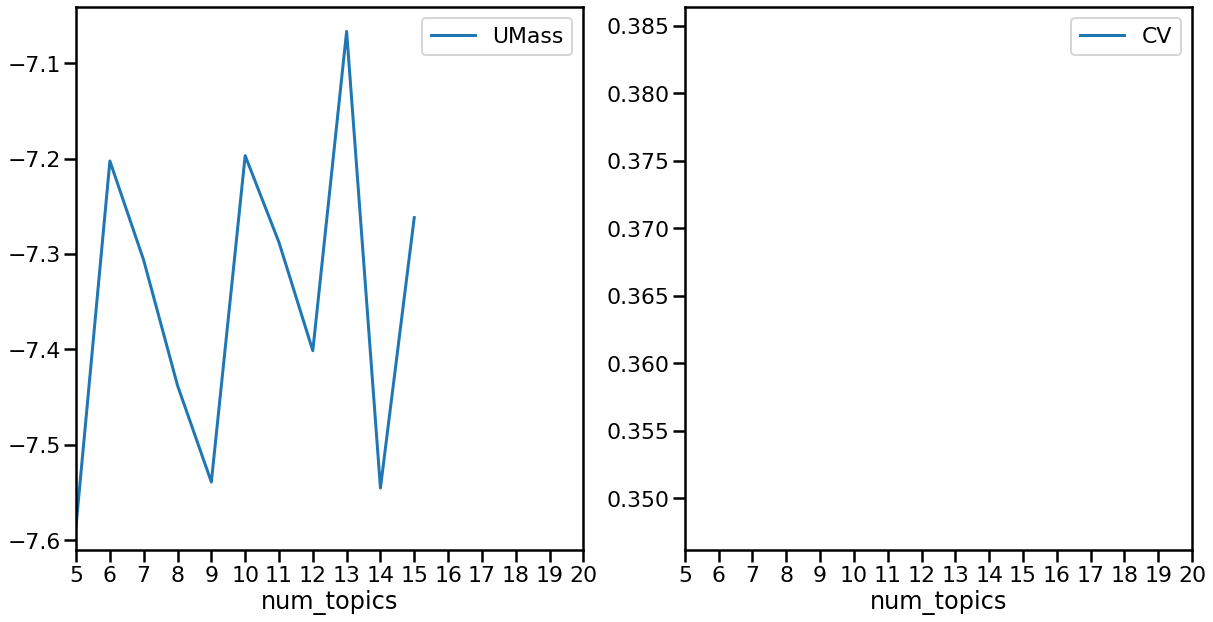

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context('poster') # use large font


scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));

In [40]:
num_topics = 13

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-3),  # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5,
                     #,random_state = 42
                    )
    
print("done in {}".format(time.time()-start), flush=True)

1087.7
fitting model


Traceback (most recent call last):
  File "/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._s

KeyboardInterrupt: 

In [20]:
# transform the data into topic distros
topic_corpus = model[model_corpus]

topic_corpus[0]

[(0, 0.06391889),
 (1, 0.061326396),
 (2, 0.06673449),
 (3, 0.1333273),
 (4, 0.054375216),
 (5, 0.07011004),
 (6, 0.06295476),
 (7, 0.14216737),
 (8, 0.07901729),
 (9, 0.053037103),
 (10, 0.07037576),
 (11, 0.07855348),
 (12, 0.06410187)]

In [21]:
import re

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "group", "cluster", "country", "individual", "effect"
2 "patient", "age", "disease", "datum", "clinical"
3 "game", "population", "evolutionary", "selection", "theory"
4 "spread", "price", "risk", "option", "volatility"
5 "equation", "force", "system", "diffusion", "differential"
6 "risk", "stock", "theory", "decision", "correlation"
7 "neural", "neuron", "image", "network", "activity"
8 "strategy", "agent", "mutation", "equilibrium", "market"
9 "cell", "cancer", "gene", "expression", "genetic"
10 "tree", "graph", "network", "inference", "method"
11 "genome", "test", "energy", "sequence", "method"
12 "protein", "flow", "growth", "system", "structure"
13 "brain", "learning", "network", "classification", "machine"


Very interesting! Topics 2,3,5,7,9,11,12 seem to highly realted to biology; while the rest are more related to economics and finance. This is precisely the type of analysis that I would do to answer my 2nd question, on a much larger set of paper and by decades.